Analyses properties of decorrelation and whitening methods for FC and Convolutional cases.

In [1]:
import numpy as np
import torch
from decorrelation.decorrelation import lower_triangular, Decorrelation, DecorConv2d # DecorrelationPatch2d # covariance, DecorrelationPatch2d, DecorrelationFC, lower_triangular
from decorrelation.plotting import *
from decorrelation.training import generate_correlated_data

# automatic reloading of modules when they change
%load_ext autoreload
%autoreload 2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
def decorrelate(num_epochs, data, model, decor_lr):

    # covariance matrix before training
    X = model.decorrelate(data).view(data.shape[0],-1)
    A1 = (X.T @ X) / len(X)

    # train decorrelator
    L = np.zeros(num_epochs)
    for i in range(num_epochs):
        model.forward(data)
        L[i] = model.update()
        model.weight -= decor_lr * model.weight.grad
        if model.bias is not None:
            model.bias -= decor_lr * model.bias.grad
        
        print(f'iteration {i}\tloss: {L[i]:.3f}')

    # covariance matrix after training
    X = model.decorrelate(data).view(data.shape[0],-1)
    A2 = (X.T @ X) / len(X)

    return L, A1, A2

We start by showing effective decorrelation of correlated input

In [3]:
num_samples=1000
num_features=100
num_epochs=200
seed=42
decor_lr=1e-1
kappa=1e-1

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

# generate correlated data
data = generate_correlated_data(num_features, num_samples).to(device)

# create a decorrelator
model = Decorrelation(in_features=num_features, bias=False, kappa=kappa).to(device)

L, A1, A2 = decorrelate(num_epochs, data, model, decor_lr)


iteration 0	loss: 411.841
iteration 1	loss: 245.627
iteration 2	loss: 35.938
iteration 3	loss: 7.691
iteration 4	loss: 4.714
iteration 5	loss: 3.529
iteration 6	loss: 2.882
iteration 7	loss: 2.463
iteration 8	loss: 2.161
iteration 9	loss: 1.928
iteration 10	loss: 1.741
iteration 11	loss: 1.584
iteration 12	loss: 1.450
iteration 13	loss: 1.333
iteration 14	loss: 1.231
iteration 15	loss: 1.140
iteration 16	loss: 1.059
iteration 17	loss: 0.986
iteration 18	loss: 0.920
iteration 19	loss: 0.860
iteration 20	loss: 0.806
iteration 21	loss: 0.756
iteration 22	loss: 0.710
iteration 23	loss: 0.668
iteration 24	loss: 0.630
iteration 25	loss: 0.594
iteration 26	loss: 0.561
iteration 27	loss: 0.530
iteration 28	loss: 0.501
iteration 29	loss: 0.474
iteration 30	loss: 0.449
iteration 31	loss: 0.425
iteration 32	loss: 0.402
iteration 33	loss: 0.380
iteration 34	loss: 0.360
iteration 35	loss: 0.340
iteration 36	loss: 0.321
iteration 37	loss: 0.302
iteration 38	loss: 0.285
iteration 39	loss: 0.268
itera

mean variance: 1.00


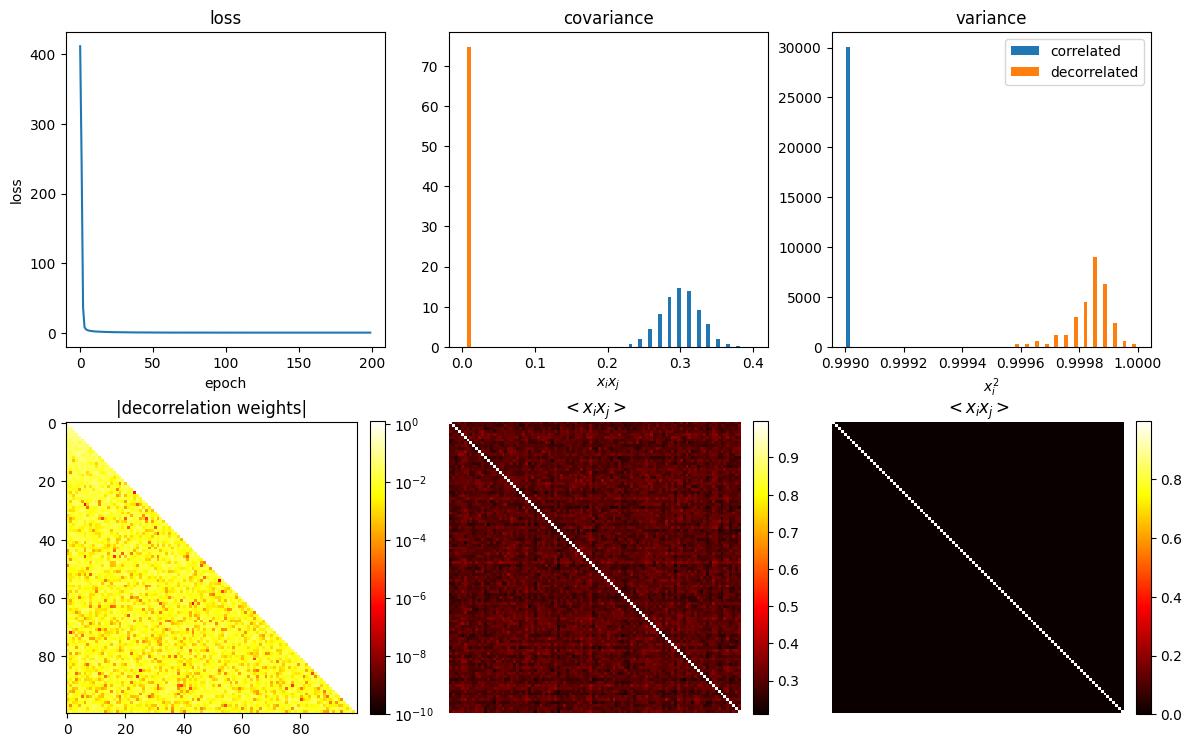

In [4]:
plot_decorrelation_results(model, L, A1, A2)
print(f'mean variance: {torch.mean(torch.diag(A2)):.2f}')

Decorrelation of correlated input using DecorConv2d

In [5]:
# generate [N, M] correlated input
num_examples=1000
in_channels=2
out_channels=3
height=10
width=10
kernel_size=(3,3)
num_samples=1000
num_epochs=200
seed=42
decor_lr=1e-1
kappa=1e-1
downsample_perc=0.1

num_features=in_channels*height*width
size = in_channels * np.prod(kernel_size)

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

data = generate_correlated_data(num_features, num_samples).reshape(num_examples,in_channels,height,width).to(device)

# d = torch.distributions.MultivariateNormal(torch.zeros(num_features), 0.1 * torch.eye(num_features) + 0.9 * torch.ones((num_features, num_features)))
# data = d.sample((num_examples,)).reshape(num_examples,in_channels,height,width).to(device)

# create a convolutional decorrelator
# NOTE: how many samples for effective input decorrelation? Dependence on dim?
# nr of samples instead of perc?
# NOTE: version for immediate non-batched decorrelation...
model = DecorConv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, bias=False, kappa=kappa, downsample_perc=downsample_perc).to(device)

L, A1, A2 = decorrelate(num_epochs, data, model, decor_lr) 


iteration 0	loss: 131.701
iteration 1	loss: 6.915
iteration 2	loss: 4.042
iteration 3	loss: 3.390
iteration 4	loss: 2.107
iteration 5	loss: 2.336
iteration 6	loss: 1.723
iteration 7	loss: 1.845
iteration 8	loss: 1.969
iteration 9	loss: 1.581
iteration 10	loss: 1.546
iteration 11	loss: 1.451
iteration 12	loss: 1.355
iteration 13	loss: 1.326
iteration 14	loss: 1.360
iteration 15	loss: 1.284
iteration 16	loss: 1.344
iteration 17	loss: 1.232
iteration 18	loss: 1.225
iteration 19	loss: 1.146
iteration 20	loss: 1.189
iteration 21	loss: 1.094
iteration 22	loss: 1.101
iteration 23	loss: 1.211
iteration 24	loss: 1.058
iteration 25	loss: 1.071
iteration 26	loss: 0.981
iteration 27	loss: 0.991
iteration 28	loss: 0.989
iteration 29	loss: 0.935
iteration 30	loss: 0.945
iteration 31	loss: 0.927
iteration 32	loss: 0.907
iteration 33	loss: 0.859
iteration 34	loss: 0.857
iteration 35	loss: 0.782
iteration 36	loss: 0.837
iteration 37	loss: 0.761
iteration 38	loss: 0.812
iteration 39	loss: 0.738
iteratio

mean variance: 1.00


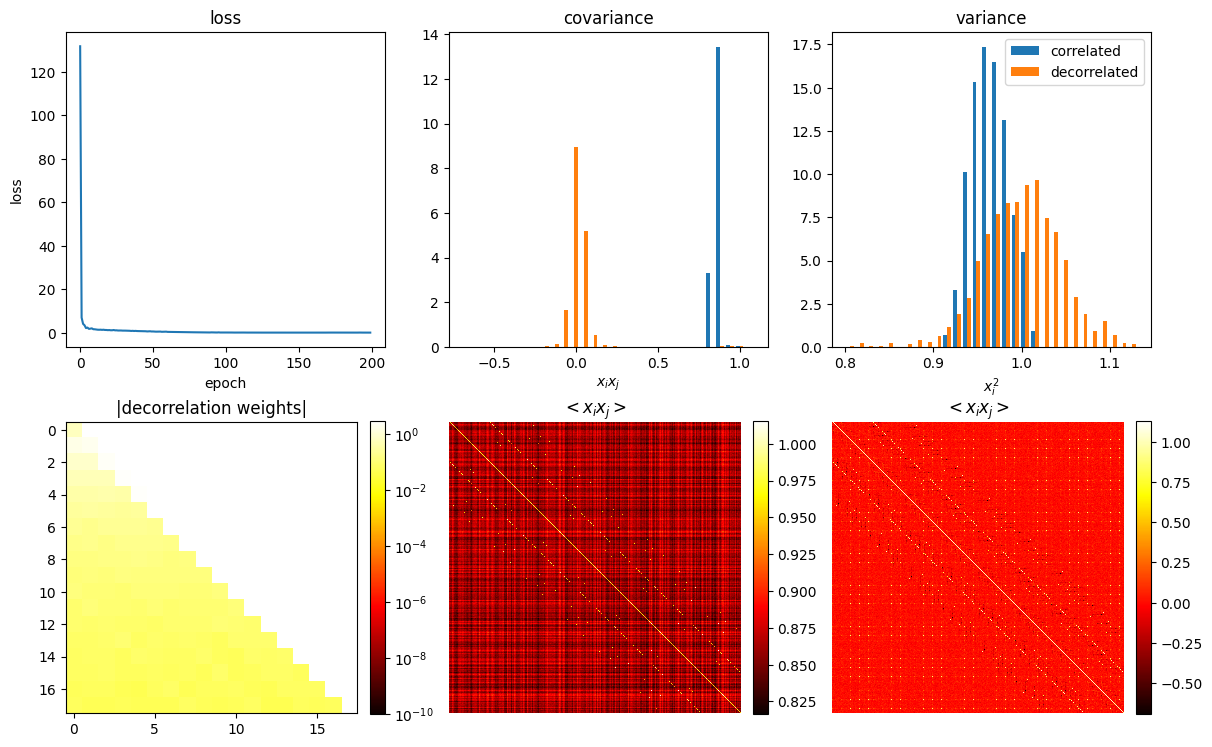

In [6]:
plot_decorrelation_results(model, L, A1, A2)
print(f'mean variance: {torch.mean(torch.diag(A2)):.2f}')